import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [1]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

#sys.path.append('/home/skong2/project/dpff4ldl')
#from utils.metrics import *
#from utils.metrics import *
#from utils.flow_functions import *
#from models.pem import *
#from models.PEM_compact import *
#from fetchData.datasetCOMBINED import *
#from trainingProtocol.trainval_COM2s_intFlow_LazyPrior_bidirection import *
#from trainingProtocol.trainval_COM2s_intFlow_sLazyPrior_bidirectionAllLayers import *
#from losses import *
#from losses_suppl import *

from utils.flow_functions import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
1.1.0


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

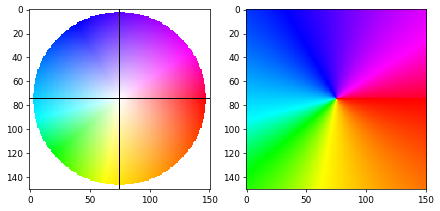

In [2]:
objDemoShowFlow = DemoShowFlow() # height=int(Y.max()), width=int(Y.max())

figWinNumHeight, figWinNumWidth = 1, 2
plt.figure(figsize=(figWinNumWidth*4,figWinNumHeight*4), dpi=64, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1   

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(objDemoShowFlow.FlowColorChart)

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(objDemoShowFlow.FlowColorChartNoAxes)

#misc.imsave(os.path.join(save_dir, 'colorchar.png'.format(idx)), objDemoShowFlow.FlowColorChart*255, format='png')

In [3]:
path_to_image = '/home/skong2/restore/dataset/pollenProject_dataset_part1'
path_to_label = '/home/skong2/restore/dataset/pollenProject_dataset_mask'
path_to_annotCombo = '/home/skong2/restore/dataset/pollenProject_dataset_annotationCombo'

#if not os.path.exists(path_to_annotCombo): 
#    os.makedirs(path_to_annotCombo)

labelIdx = []
samplePathList = []
labelNameList = []
labelIDxList = []
labelIdxCount = 0
annotComboList = []
dict_classCount = dict()
dict_classSampleList = dict()
for subfolder in os.listdir(path_to_image):            
    set_path = []
    tmpSampleList = os.listdir(path.join(path_to_image, subfolder))# self.sorted_dir
    if len(tmpSampleList)>=1:
        dict_classCount[subfolder] = len(tmpSampleList)
        dict_classSampleList[subfolder] = []
        for sampleFile in tmpSampleList: # self.sorted_dir
            if sampleFile.endswith((".png","_files")): 
                samplePathList += [path.join(subfolder, sampleFile[:-4])]
                dict_classSampleList[subfolder] += [path.join(subfolder, sampleFile[:-4])]
                labelNameList += [subfolder]
                labelIDxList += [labelIdxCount]                 
        labelIdxCount += 1

# for subfolder in os.listdir(path_to_annotCombo):            
#     set_path = []
#     tmpSampleList = os.listdir(path.join(path_to_annotCombo, subfolder))# self.sorted_dir
#     if len(tmpSampleList)>=1:        
#         for sampleFile in tmpSampleList: # self.sorted_dir
#             if sampleFile.endswith((".pkl","_files")): 
#                 annotComboList += [path.join(subfolder, sampleFile[:-4])]

In [4]:
train_det_dict = {}
test_det_dict = {}
train_det_list = []
test_det_list = []
train_det_className = []
test_det_className = []
train_det_classID = []
test_det_classID = []

trRatio = 0.8
classCount = 0
for key in dict_classSampleList:
    tmpSmpList = dict_classSampleList[key]
    if len(tmpSmpList)>5:
        trNum = round(len(tmpSmpList)*trRatio)
        tsNum = len(tmpSmpList) - trNum
        train_det_dict[key] = tmpSmpList[:trNum]
        test_det_dict[key] = tmpSmpList[trNum:]
        
        train_det_list += tmpSmpList[:trNum]
        test_det_list += tmpSmpList[trNum:]        
        train_det_className += [key]*trNum
        test_det_className += [key]*tsNum
        train_det_classID += [classCount]*trNum
        test_det_classID += [classCount]*tsNum        
    else: 
        train_det_dict[key] = tmpSmpList
        train_det_list += tmpSmpList
        train_det_className += [key]*len(tmpSmpList)
        train_det_classID += [classCount]*len(tmpSmpList)
        
    classCount += 1

In [5]:
dbinfo = {}
dbinfo['train_det_list'] = train_det_list
dbinfo['test_det_list'] = test_det_list
dbinfo['train_det_className'] = train_det_className
dbinfo['test_det_className'] = test_det_className
dbinfo['train_det_classID'] = train_det_classID
dbinfo['test_det_classID'] = test_det_classID

with open('dbinfo.plk', 'wb') as handle:
    pickle.dump(dbinfo, handle) # , protocol=pickle.HIGHEST_PROTOCOL

In [6]:
with open('dbinfo.plk', 'rb') as handle:
    dbinfo = pickle.load(handle)

dbinfo.keys(), len(dbinfo['train_det_list']), len(dbinfo['test_det_list'])

(dict_keys(['train_det_list', 'test_det_list', 'train_det_className', 'test_det_className', 'train_det_classID', 'test_det_classID']),
 4997,
 1218)

In [12]:
idx = 29

path_to_image = '/home/skong2/restore/dataset/pollenProject_dataset_part1'
path_to_annotCombo = '/home/skong2/restore/dataset/pollenProject_dataset_annotationCombo'

curClassName = dbinfo['train_det_className'][idx]
curImageName = path.join(path_to_image, dbinfo['train_det_list'][idx]+'.png')
curPickleName = path.join(path_to_annotCombo, dbinfo['train_det_list'][idx]+'.pkl')

with open(curPickleName, 'rb') as handle:
    annot = pickle.load(handle)

In [13]:
image = PIL.Image.open(curImageName)
image = np.array(image)

label = np.zeros((annot['size'][0], annot['size'][1]))

mask_distanceTransform = label*0.
mask_peaks = label*0.
mask_radius = label*0.
mask_voteX = label*0.
mask_voteY = label*0.
mask_overlap = label*0.
for i in range(annot['coord_peaks'].shape[0]):
    y, x = annot['coord_peaks'][i]
    r = annot['mask_radius'][i]
    
    mask_peaks[y-10:y+10, x-10:x+10] = 1
    mask_radius[y-10:y+10, x-10:x+10] = r
    #mask_peaks[y, x] = 1
    #mask_radius[y, x] = r
    
    mask_x, mask_y = np.asarray(range(label.shape[1])).astype(np.float), np.asarray(range(label.shape[0])).astype(np.float)
    mask_x, mask_y = np.meshgrid(mask_x, mask_y)
    mask_x = float(x) - mask_x
    mask_y = float(y) - mask_y
    
    tmpDistTransform = np.sqrt(mask_x*mask_x + mask_y*mask_y)
    tmpmask_vote = tmpDistTransform <= r
    label[tmpmask_vote] = 1
    mask_voteX[tmpmask_vote] = mask_x[tmpmask_vote]
    mask_voteY[tmpmask_vote] = mask_y[tmpmask_vote]
    mask_distanceTransform[tmpmask_vote] = r-tmpDistTransform[tmpmask_vote]
    mask_overlap += tmpmask_vote.astype(np.float)
mask_overlap = mask_overlap>1
mask_overlap = mask_overlap.astype(np.uint8)   

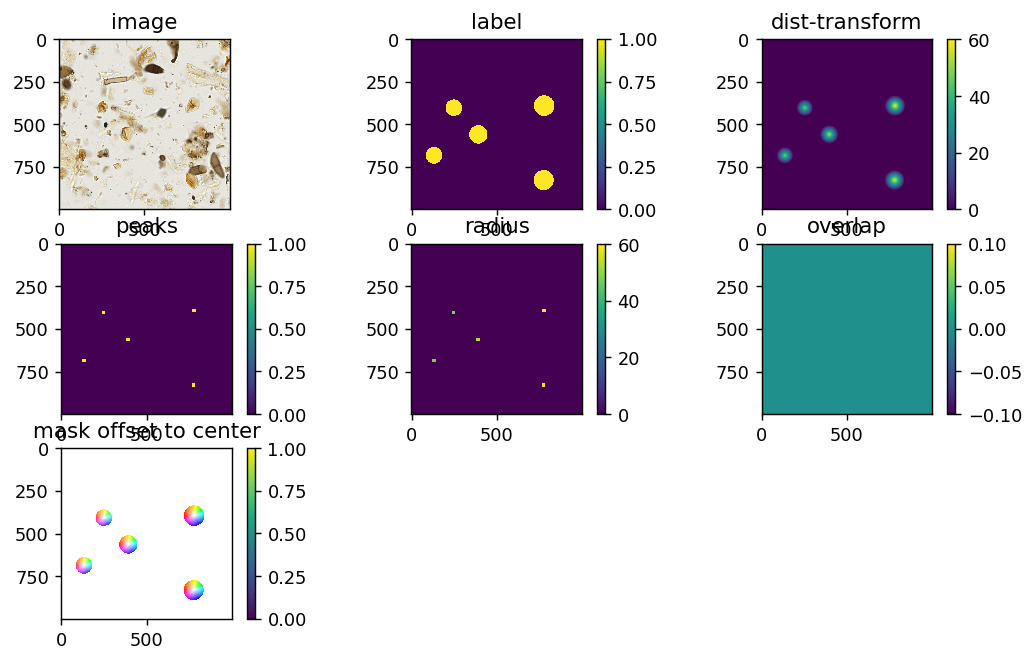

In [14]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = 3, 3
plt.figure(figsize=(10, 6), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(image)
#plt.axis('off')
plt.title('image')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(label)
#plt.axis('off')
plt.title('label')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(mask_distanceTransform)
#plt.axis('off')
plt.title('dist-transform')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(mask_peaks)
#plt.axis('off')
plt.title('peaks')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(mask_radius)
#plt.axis('off')
plt.title('radius')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(mask_overlap)
#plt.axis('off')
plt.title('overlap')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
flowVisShow = objDemoShowFlow.computeColor(
    mask_voteX/np.abs(mask_voteX).max(), 
    mask_voteY/np.abs(mask_voteY).max())/255.    
plt.imshow(flowVisShow)
#plt.axis('off')
plt.title('mask offset to center')
plt.colorbar()

In [11]:
type(image), image.shape, image.max(), image.min()

(numpy.ndarray, (1000, 1000, 3), 255, 16)



Leaving Blank
-----